<br/>

# < 자연어처리를 활용한 과거 1997년~2000년대 축구일기 분석 >

## 1. 데이터 선정 과정

- 책 출판을 위해 텍스트화 했었던 초등학교 시절 썼던 일기(1997년에서 2003년 사이 총 205개)들을 바탕으로 당시 본인의 축구라는 분야에 있어 생각하고, 관심있어 하는 부분을 자연어처리라는 방법을 통해 텍스트를 분석하여 이를 바탕으로 좀 더 실제적인 접근방식들로 근거들을 직접 알아보고자 이 프로젝트를 진행하게 되었다
- 아래 사진은 (1998년 9월 28일 일요일에 본인이 썼던 첫 축구일기) => 일명 '도쿄대첩'이라 불리는 경기였다.

![일기](http://postfiles16.naver.net/20150511_15/owena88_1431333409802rqbKr_JPEG/fas.JPG?type=w3)

## 2. 데이터 분석의 개요 및 목적

  * 분석주제 : 날짜와 내용이 있는 데이터로 당시 시대별 축구 관련 상황이나 그 상황을 바라보며 쓴 나만의 관점들을 시각화
  

  * 분석과정 : WorkFlow에 따라 진행
  
              (1) EDA(그래프를 통한 탐색적 자료분석) & 전처리 과정
                  > 텍스트의 명사 추출 및 품사 태깅
                  > 유의미한 텍스트 추출(한 글자 이상의 명사, 형용사, 동사로 구성되어진 단어)
                  
              (2) 텍스트 분석
                  > lda로 특정 문서가 만들어질 확률 체크
                  > 워드 클라우드 그리기(전체 일기 텍스트)
                  > Word2Vec으로 일기 속에 드러난 단어간의 유사도 체크
                  > Word2Vec으로 도출된 단어들로 t-sne를 통해 차원축소를 하여 시각화
                
              (3) 텍스트 생성
                  > 딥러닝의 RNN 모델을 통해 일기 데이터를 학습시키고 또다른 일기를 생성
                
  * 분석모델 : lda, Word2Vec, T-sne, RNN        

## 3. 탐색적 자료 분석 (EDA : Exploratory Data Analysis) & 전처리(Preprocessing)

In [2]:
import sys
import codecs

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import pylab as Plot
%matplotlib inline
import seaborn as sns

import nltk
from nltk import collocations
from nltk.corpus import treebank
from nltk.tokenize import sent_tokenize

from konlpy.tag import Kkma
from konlpy.tag import Twitter
from konlpy.tag import Hannanum
from konlpy.utils import pprint

from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

from collections import Counter
from asq.initiators import query


#### - 과거 초등학교 시절 일기라 맞춤법이 간혹 안 맞는 경우들이 많고, 카테고리가 축구이니만큼 관련 단어들이 많이 있다. 전처리 과정은 다음과 같다.

In [3]:
# 데이터 수집 및 불러오기

diary_file = 'data/football_diary.txt'

with open(diary_file) as f:
    text = f.read()

In [4]:
# 데이터 확인

print (text[:500])
print (type(text)) # type은 문자열

#1. 1997년 9월 28일 일요일 날씨 : 맑음

주제 : 역전승을 올린 자랑스런 우리나라 한국 대표단 선수 아저씨들 파이팅!

  월드컵 최종 경기가 시작되었다. 응원석에는 붉은 악마들의 응원이 불타 올랐다. 처음에는 우리나라들이 공격을 했지만 골은 허용되지 않았다. 그런데 일본이 공격을 해 왔다. 고정운 선수 아저씨의 실수로 일본이 골인을 했다. 하지만 한국 대표단 선수 아저씨들의 끈기와 노력으로 최용수 아저씨의 패스 서정원 아저씨의 헤딩 슛! 동점골인이 터졌다. 붉은 악마 응원단들은 흥분을 하며 날뛰고 기분이 무척 좋았을 것이다. 나도 기분이 아주 좋았다. 일본의 응원단들은 축 늘어졌다. 붉은 악마들은 응원을 열심히 하였다.
  “한국 이겨라! 일본 져라!”
  동점골을 터뜨린 서정원 아저씨는 별명이 날쌘돌이라고 불리고 있었다. 일본의 미우라 아저씨는 잘해서 최용수 아저씨 등 여러 선수 아저씨들의 조체이 당해서 동점골을 넣었다. 가정이나 텔레비전이 있는 곳은 사람들이 몰려와
<class 'str'>


-------------------

#### - konlpy를 통해 한 글자 이상으로 구성된 명사를 추출하여 진행(일단 stopwords는 제외시킴)

In [5]:
# konlpy 라이브러리의 Twitter 모듈로 명사만을 추출

tw = Twitter()

diary_nouns = tw.nouns(text)
print (diary_nouns[0:40])
print (type(diary_nouns))

['년', '월', '일', '일요일', '날씨', '맑음', '주제', '역전승', '우리나라', '한국', '대표', '단', '선수', '아저씨', '파이팅', '월드컵', '최종', '경기', '응원', '석', '악마', '응원', '불타', '처음', '우리나라', '공격', '일본', '공격', '해', '고정운', '선수', '아저씨', '실수', '일본', '골인', '한국', '대표', '단', '선수', '아저씨']
<class 'list'>


In [6]:
# 명사 중에 한글자 이상으로 된 명사만 추출 (Corpus 대체 가능)

diary_nouns_filter = []

for noun in diary_nouns:
    if len(noun) > 1:
        diary_nouns_filter.append(noun)
        
print (diary_nouns_filter[:100])

['일요일', '날씨', '맑음', '주제', '역전승', '우리나라', '한국', '대표', '선수', '아저씨', '파이팅', '월드컵', '최종', '경기', '응원', '악마', '응원', '불타', '처음', '우리나라', '공격', '일본', '공격', '고정운', '선수', '아저씨', '실수', '일본', '골인', '한국', '대표', '선수', '아저씨', '끈기', '노력', '최용수', '아저씨', '패스', '서정원', '아저씨', '헤딩', '동점골', '악마', '응원단', '흥분', '기분', '무척', '기분', '아주', '일본', '응원단', '악마', '응원', '한국', '일본', '동점골', '서정원', '아저씨', '별명', '날쌘돌이', '불리', '일본', '미우라', '아저씨', '최용수', '아저씨', '여러', '선수', '아저씨', '조체', '동점골', '가정', '텔레비전', '사람', '일본', '한국', '전반전', '후반', '일본', '골인', '후반', '우리나라', '동점골', '정말', '아슬아슬', '한국', '전반전', '후반전', '일본', '우리나라', '생각', '선수', '실력', '코너킥', '후반전', '후반', '일본', '야마구치', '선수', '골인']


In [7]:
len(diary_nouns_filter)

12473

-----

#### - 품사 태깅 후, 한 글자 이상으로 된 명사, 형용사, 동사 부분만 추출하여 진행

In [8]:
# Twitter 모듈로 품사태깅

diary_pos = tw.pos(text)
print (diary_pos[10:20])
print (type(diary_pos))

print (diary_pos[20][0])
print (type(diary_pos[20][0]))

[('날씨', 'Noun'), (':', 'Punctuation'), ('맑음', 'Noun'), ('주제', 'Noun'), (':', 'Punctuation'), ('역전승', 'Noun'), ('을', 'Josa'), ('올린', 'Verb'), ('자랑스런', 'Adjective'), ('우리나라', 'Noun')]
<class 'list'>
한국
<class 'str'>


In [9]:
# 품사 태깅한 것 중 의미있는 부분만 뽑음(Noun, Adjective, Verb)

diary_chosen_token = []

for i in range(len(diary_pos)):
    
    if diary_pos[i][1] == 'Noun':
        diary_chosen_token.append(diary_pos[i])
    elif diary_pos[i][1] == 'Adjective':
        diary_chosen_token.append(diary_pos[i])
    elif diary_pos[i][1] == 'Verb':
        diary_chosen_token.append(diary_pos[i])

print (diary_chosen_token[:100])

[('년', 'Noun'), ('월', 'Noun'), ('일', 'Noun'), ('일요일', 'Noun'), ('날씨', 'Noun'), ('맑음', 'Noun'), ('주제', 'Noun'), ('역전승', 'Noun'), ('올린', 'Verb'), ('자랑스런', 'Adjective'), ('우리나라', 'Noun'), ('한국', 'Noun'), ('대표', 'Noun'), ('단', 'Noun'), ('선수', 'Noun'), ('아저씨', 'Noun'), ('파이팅', 'Noun'), ('월드컵', 'Noun'), ('최종', 'Noun'), ('경기', 'Noun'), ('시작되', 'Verb'), ('응원', 'Noun'), ('석', 'Noun'), ('붉은', 'Adjective'), ('악마', 'Noun'), ('응원', 'Noun'), ('불타', 'Noun'), ('올랐', 'Verb'), ('처음', 'Noun'), ('우리나라', 'Noun'), ('공격', 'Noun'), ('골은', 'Verb'), ('허용되', 'Verb'), ('않았', 'Verb'), ('일본', 'Noun'), ('공격', 'Noun'), ('해', 'Noun'), ('왔', 'Verb'), ('고정운', 'Noun'), ('선수', 'Noun'), ('아저씨', 'Noun'), ('실수', 'Noun'), ('일본', 'Noun'), ('골인', 'Noun'), ('했', 'Verb'), ('한국', 'Noun'), ('대표', 'Noun'), ('단', 'Noun'), ('선수', 'Noun'), ('아저씨', 'Noun'), ('끈기', 'Noun'), ('노력', 'Noun'), ('최용수', 'Noun'), ('아저씨', 'Noun'), ('패스', 'Noun'), ('서정원', 'Noun'), ('아저씨', 'Noun'), ('헤딩', 'Noun'), ('슛', 'Noun'), ('동점골', 'Noun'), ('터졌', 'Verb'), ('

In [10]:
# 유의미한 내용 도출을 위해 한 글자로 된 부분 제거

diary_chosen_filter = []

for j in range(len(diary_chosen_token)):
    if len(diary_chosen_token[j][0]) > 1:
        diary_chosen_filter.append(diary_chosen_token[j])
        
print (diary_chosen_filter[:100])

[('일요일', 'Noun'), ('날씨', 'Noun'), ('맑음', 'Noun'), ('주제', 'Noun'), ('역전승', 'Noun'), ('올린', 'Verb'), ('자랑스런', 'Adjective'), ('우리나라', 'Noun'), ('한국', 'Noun'), ('대표', 'Noun'), ('선수', 'Noun'), ('아저씨', 'Noun'), ('파이팅', 'Noun'), ('월드컵', 'Noun'), ('최종', 'Noun'), ('경기', 'Noun'), ('시작되', 'Verb'), ('응원', 'Noun'), ('붉은', 'Adjective'), ('악마', 'Noun'), ('응원', 'Noun'), ('불타', 'Noun'), ('올랐', 'Verb'), ('처음', 'Noun'), ('우리나라', 'Noun'), ('공격', 'Noun'), ('골은', 'Verb'), ('허용되', 'Verb'), ('않았', 'Verb'), ('일본', 'Noun'), ('공격', 'Noun'), ('고정운', 'Noun'), ('선수', 'Noun'), ('아저씨', 'Noun'), ('실수', 'Noun'), ('일본', 'Noun'), ('골인', 'Noun'), ('한국', 'Noun'), ('대표', 'Noun'), ('선수', 'Noun'), ('아저씨', 'Noun'), ('끈기', 'Noun'), ('노력', 'Noun'), ('최용수', 'Noun'), ('아저씨', 'Noun'), ('패스', 'Noun'), ('서정원', 'Noun'), ('아저씨', 'Noun'), ('헤딩', 'Noun'), ('동점골', 'Noun'), ('터졌', 'Verb'), ('붉은', 'Adjective'), ('악마', 'Noun'), ('응원단', 'Noun'), ('흥분', 'Noun'), ('하며', 'Verb'), ('날뛰', 'Adjective'), ('기분', 'Noun'), ('무척', 'Noun'), ('나도', 'Verb'

<br/>

## 4. 일기 텍스트 분석

### (1) LDA

LDA(Latent Dirichlet Allocation)는 문서같은 데이터의 집합에 대한 generative probabilistic model
- generative model : 문서의 주제 분포와 각 주제별로 특정 단어를 생성한 확률을 알고 있으면, 특정 문서가 만들어질 확률을 계산

In [11]:
diary_nouns_filter[:10]

['일요일', '날씨', '맑음', '주제', '역전승', '우리나라', '한국', '대표', '선수', '아저씨']

In [12]:
diary_double_list = []
for i in diary_nouns_filter:
    diary_double_list.append([i])

print(diary_double_list[:100])

[['일요일'], ['날씨'], ['맑음'], ['주제'], ['역전승'], ['우리나라'], ['한국'], ['대표'], ['선수'], ['아저씨'], ['파이팅'], ['월드컵'], ['최종'], ['경기'], ['응원'], ['악마'], ['응원'], ['불타'], ['처음'], ['우리나라'], ['공격'], ['일본'], ['공격'], ['고정운'], ['선수'], ['아저씨'], ['실수'], ['일본'], ['골인'], ['한국'], ['대표'], ['선수'], ['아저씨'], ['끈기'], ['노력'], ['최용수'], ['아저씨'], ['패스'], ['서정원'], ['아저씨'], ['헤딩'], ['동점골'], ['악마'], ['응원단'], ['흥분'], ['기분'], ['무척'], ['기분'], ['아주'], ['일본'], ['응원단'], ['악마'], ['응원'], ['한국'], ['일본'], ['동점골'], ['서정원'], ['아저씨'], ['별명'], ['날쌘돌이'], ['불리'], ['일본'], ['미우라'], ['아저씨'], ['최용수'], ['아저씨'], ['여러'], ['선수'], ['아저씨'], ['조체'], ['동점골'], ['가정'], ['텔레비전'], ['사람'], ['일본'], ['한국'], ['전반전'], ['후반'], ['일본'], ['골인'], ['후반'], ['우리나라'], ['동점골'], ['정말'], ['아슬아슬'], ['한국'], ['전반전'], ['후반전'], ['일본'], ['우리나라'], ['생각'], ['선수'], ['실력'], ['코너킥'], ['후반전'], ['후반'], ['일본'], ['야마구치'], ['선수'], ['골인']]


In [27]:
# gensim 라이브러리를 이용하여 token 보기

from gensim import corpora, models

dictionary = corpora.Dictionary(diary_double_list)

In [28]:
print (dictionary)
type(dictionary)

Dictionary(2169 unique tokens: ['일요일', '날씨', '맑음', '주제', '역전승']...)


gensim.corpora.dictionary.Dictionary

In [29]:
# 문장별 리스트화

import re
remove_ = ''.join(open('data/football_diary.txt').readlines())
diary_sentences = re.split(r' *[\.\?!][\'"\)\]]* *', remove_)
type(diary_sentences)
print (diary_sentences[:50])
# = str(diary_sentences)

['#1', '1997년 9월 28일 일요일 날씨 : 맑음\n\n주제 : 역전승을 올린 자랑스런 우리나라 한국 대표단 선수 아저씨들 파이팅', '\n\n  월드컵 최종 경기가 시작되었다', '응원석에는 붉은 악마들의 응원이 불타 올랐다', '처음에는 우리나라들이 공격을 했지만 골은 허용되지 않았다', '그런데 일본이 공격을 해 왔다', '고정운 선수 아저씨의 실수로 일본이 골인을 했다', '하지만 한국 대표단 선수 아저씨들의 끈기와 노력으로 최용수 아저씨의 패스 서정원 아저씨의 헤딩 슛', '동점골인이 터졌다', '붉은 악마 응원단들은 흥분을 하며 날뛰고 기분이 무척 좋았을 것이다', '나도 기분이 아주 좋았다', '일본의 응원단들은 축 늘어졌다', '붉은 악마들은 응원을 열심히 하였다', '\n  “한국 이겨라', '일본 져라', '”\n  동점골을 터뜨린 서정원 아저씨는 별명이 날쌘돌이라고 불리고 있었다', '일본의 미우라 아저씨는 잘해서 최용수 아저씨 등 여러 선수 아저씨들의 조체이 당해서 동점골을 넣었다', '가정이나 텔레비전이 있는 곳은 사람들이 몰려와서 일본과 한국이 하는 것을 보았다', '전반전에는 0-0 으로 마쳤는데 후반 몇 분 안되서 일본이 골인을 넣었고 후반 38분에 우리나라가 동점골 1-1을 허용했다', '정말 아슬아슬 하였다', '\n  “한국 이겨라', '”\n  전반전 0-0으로 끝났지만 후반전에는 일본이 1점을 먹었다', '그 때는 우리나라가 질 것이라고 생각을 했는데 그렇지 않았다', '선수들이 실력을 발휘하였다', '코너킥을 후반전에는 1번을 하였다', '후반 몇 분에 일본 야마구치 선수가 골인을 넣었고, 우리나라는 서정원 선수 아저씨의 동점골로 안심을 시켰다', '또 후반 41분에 이민성 선수 아저씨의 골인이었다', '\n  한국 : 2 일본 : 1 정말 좋았다', '이민성 선수 아저씨가 골인을 눌 때 속이 후련하였다', '\n  “한국 파이팅', '”\n  한국은 일본을 2대1로 낚아채었다', '나는 흥분이 되어서 소리를 질

In [30]:
sentence_listup = []

for sentence_list in diary_sentences:
    sentence_voca = sentence_list.split(' ')
    sentence_listup.append(sentence_voca)
print (sentence_listup[:30])

[['#1'], ['1997년', '9월', '28일', '일요일', '날씨', ':', '맑음\n\n주제', ':', '역전승을', '올린', '자랑스런', '우리나라', '한국', '대표단', '선수', '아저씨들', '파이팅'], ['\n\n', '', '월드컵', '최종', '경기가', '시작되었다'], ['응원석에는', '붉은', '악마들의', '응원이', '불타', '올랐다'], ['처음에는', '우리나라들이', '공격을', '했지만', '골은', '허용되지', '않았다'], ['그런데', '일본이', '공격을', '해', '왔다'], ['고정운', '선수', '아저씨의', '실수로', '일본이', '골인을', '했다'], ['하지만', '한국', '대표단', '선수', '아저씨들의', '끈기와', '노력으로', '최용수', '아저씨의', '패스', '서정원', '아저씨의', '헤딩', '슛'], ['동점골인이', '터졌다'], ['붉은', '악마', '응원단들은', '흥분을', '하며', '날뛰고', '기분이', '무척', '좋았을', '것이다'], ['나도', '기분이', '아주', '좋았다'], ['일본의', '응원단들은', '축', '늘어졌다'], ['붉은', '악마들은', '응원을', '열심히', '하였다'], ['\n', '', '“한국', '이겨라'], ['일본', '져라'], ['”\n', '', '동점골을', '터뜨린', '서정원', '아저씨는', '별명이', '날쌘돌이라고', '불리고', '있었다'], ['일본의', '미우라', '아저씨는', '잘해서', '최용수', '아저씨', '등', '여러', '선수', '아저씨들의', '조체이', '당해서', '동점골을', '넣었다'], ['가정이나', '텔레비전이', '있는', '곳은', '사람들이', '몰려와서', '일본과', '한국이', '하는', '것을', '보았다'], ['전반전에는', '0-0', '으로', '마쳤는데', '후반', '몇', '분', '안되서', '일본이', '골인

In [31]:
diary_all_listup = []
for i in sentence_listup:
    diary_all_listup.append(i)

print(diary_all_listup[:30])
print (type(diary_all_listup))

[['#1'], ['1997년', '9월', '28일', '일요일', '날씨', ':', '맑음\n\n주제', ':', '역전승을', '올린', '자랑스런', '우리나라', '한국', '대표단', '선수', '아저씨들', '파이팅'], ['\n\n', '', '월드컵', '최종', '경기가', '시작되었다'], ['응원석에는', '붉은', '악마들의', '응원이', '불타', '올랐다'], ['처음에는', '우리나라들이', '공격을', '했지만', '골은', '허용되지', '않았다'], ['그런데', '일본이', '공격을', '해', '왔다'], ['고정운', '선수', '아저씨의', '실수로', '일본이', '골인을', '했다'], ['하지만', '한국', '대표단', '선수', '아저씨들의', '끈기와', '노력으로', '최용수', '아저씨의', '패스', '서정원', '아저씨의', '헤딩', '슛'], ['동점골인이', '터졌다'], ['붉은', '악마', '응원단들은', '흥분을', '하며', '날뛰고', '기분이', '무척', '좋았을', '것이다'], ['나도', '기분이', '아주', '좋았다'], ['일본의', '응원단들은', '축', '늘어졌다'], ['붉은', '악마들은', '응원을', '열심히', '하였다'], ['\n', '', '“한국', '이겨라'], ['일본', '져라'], ['”\n', '', '동점골을', '터뜨린', '서정원', '아저씨는', '별명이', '날쌘돌이라고', '불리고', '있었다'], ['일본의', '미우라', '아저씨는', '잘해서', '최용수', '아저씨', '등', '여러', '선수', '아저씨들의', '조체이', '당해서', '동점골을', '넣었다'], ['가정이나', '텔레비전이', '있는', '곳은', '사람들이', '몰려와서', '일본과', '한국이', '하는', '것을', '보았다'], ['전반전에는', '0-0', '으로', '마쳤는데', '후반', '몇', '분', '안되서', '일본이', '골인

In [32]:
dictionary_corpus = [dictionary.doc2bow(a) for a in sentence_listup]

len(dictionary_corpus)

2484

In [36]:
ldamodel = models.LdaModel(dictionary_corpus, num_topics=5, id2word = dictionary, passes = 20)

In [37]:
print (ldamodel.print_topics(num_topics = 2, num_words = 4))

[(1, '0.053*"한국" + 0.051*"우리" + 0.044*"날씨" + 0.034*"월드컵"'), (0, '0.063*"후반전" + 0.048*"우리나라" + 0.038*"모두" + 0.024*"한국"')]


In [38]:
# lda = LdaMulticore(review_corpus, num_topics=20, id2word=dictionary, workers=2)
# 

ldamodel.show_topic(0)

[('후반전', 0.063038060548638156),
 ('우리나라', 0.048000647767769376),
 ('모두', 0.037669083891084643),
 ('한국', 0.02377430988310808),
 ('이번', 0.022822058490081606),
 ('경기', 0.018013193109525257),
 ('허정무', 0.017183051177929995),
 ('화이팅', 0.01564794959935354),
 ('이동국', 0.01456679784726125),
 ('축구', 0.014438772803953113)]

In [39]:
import pyLDAvis
import pyLDAvis.gensim
import pickle

In [40]:
ldavis = pyLDAvis.gensim.prepare(topic_model = ldamodel, 
                                 corpus =dictionary_corpus, 
                                 dictionary= dictionary)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [41]:
pyLDAvis.display(ldavis)

### => LDA로 나온 결과값에 대한 분석

* LDA는 특정 토픽에 특정 단어가 나타날 확률을 부여함.

* 분포를 통한 분석

> - 1번의 경우 전체 일기 205개에 나와있는 날씨 정보는 모든 문서에 있다고 봐도 무방하다. 하지만 토픽을 통해 확률값을 뽑는 상황에서는 중요한 단어가 아닐 수 있다. 저 정도의 추정값으로 도출된 것으로 보인다.
> - 2번의 경우 축구 일기기 때문에, 모든 문서에 '축구'라는 토픽을 중심으로 이야기가 전개된다. 따라서 전체 문서에 해당하는 '축구'라는 단어에 대부분의 확률 추정치가 도출된다. '우리나라'라는 단어는 기존 본인의 관점(애국심)으로 인해 한국보다 많은 수를 차지한 것으로 보인다.
> - 3번의 경우, 볼 수 있는 부분이 단지 요일에 관한 것 밖에 없다. 
> - 4번의 경우, 프랑스 월드컵을 기준으로 토픽들이 몰려있는 것으로 보인다. 따라서, '월드컵', '프랑스', '세계'와 같은 단어로 묶여있는 것을 볼 수 있다.
> - 5번의 경우, 시드니 올림픽을 토픽으로 겨냥하고 결과값이 나온 것으로 보인다. 

---

## 시각화(Visualization)

### 시각화 (1) 토큰화 된 단어들로 구성된 그래프

#### - Noun으로만 구성된 corpus 추출

In [42]:
diary_corpus = 'intermediate/diary_nouns_filter.txt'

with open(diary_corpus) as f:
    diary_nouns_corpus = f.read()
    
diary_pos_corpus = tw.pos(diary_nouns_corpus)
print (diary_pos_corpus[:100])

[('일요일', 'Noun'), ('날씨', 'Noun'), ('맑음', 'Noun'), ('주제', 'Noun'), ('역전승', 'Noun'), ('우리나라', 'Noun'), ('한국', 'Noun'), ('대표', 'Noun'), ('선수', 'Noun'), ('아저씨', 'Noun'), ('파이팅', 'Noun'), ('월드컵', 'Noun'), ('최종', 'Noun'), ('경기', 'Noun'), ('응원', 'Noun'), ('악마', 'Noun'), ('응원', 'Noun'), ('불타', 'Noun'), ('처음', 'Noun'), ('우리나라', 'Noun'), ('공격', 'Noun'), ('일본', 'Noun'), ('공격', 'Noun'), ('고정운', 'Noun'), ('선수', 'Noun'), ('아저씨', 'Noun'), ('실수', 'Noun'), ('일본', 'Noun'), ('골인', 'Noun'), ('한국', 'Noun'), ('대표', 'Noun'), ('선수', 'Noun'), ('아저씨', 'Noun'), ('끈기', 'Noun'), ('노력', 'Noun'), ('최용수', 'Noun'), ('아저씨', 'Noun'), ('패스', 'Noun'), ('서정원', 'Noun'), ('아저씨', 'Noun'), ('헤딩', 'Noun'), ('동점골', 'Noun'), ('악마', 'Noun'), ('응원단', 'Noun'), ('흥분', 'Noun'), ('기분', 'Noun'), ('무척', 'Noun'), ('기분', 'Noun'), ('아주', 'Noun'), ('일본', 'Noun'), ('응원단', 'Noun'), ('악마', 'Noun'), ('응원', 'Noun'), ('한국', 'Noun'), ('일본', 'Noun'), ('동점골', 'Noun'), ('서정원', 'Noun'), ('아저씨', 'Noun'), ('별명', 'Noun'), ('날쌘돌이', 'Noun'), ('불리', 'Noun'),

In [43]:
# corpus(말뭉치)는 리스트의 리스트 형태로 구현
# [['응원', 'Noun'], ['일요일','Noun' ]]

corpus_sentence = [list(s) for s in diary_pos_corpus]
print (corpus_sentence[:100])

[['일요일', 'Noun'], ['날씨', 'Noun'], ['맑음', 'Noun'], ['주제', 'Noun'], ['역전승', 'Noun'], ['우리나라', 'Noun'], ['한국', 'Noun'], ['대표', 'Noun'], ['선수', 'Noun'], ['아저씨', 'Noun'], ['파이팅', 'Noun'], ['월드컵', 'Noun'], ['최종', 'Noun'], ['경기', 'Noun'], ['응원', 'Noun'], ['악마', 'Noun'], ['응원', 'Noun'], ['불타', 'Noun'], ['처음', 'Noun'], ['우리나라', 'Noun'], ['공격', 'Noun'], ['일본', 'Noun'], ['공격', 'Noun'], ['고정운', 'Noun'], ['선수', 'Noun'], ['아저씨', 'Noun'], ['실수', 'Noun'], ['일본', 'Noun'], ['골인', 'Noun'], ['한국', 'Noun'], ['대표', 'Noun'], ['선수', 'Noun'], ['아저씨', 'Noun'], ['끈기', 'Noun'], ['노력', 'Noun'], ['최용수', 'Noun'], ['아저씨', 'Noun'], ['패스', 'Noun'], ['서정원', 'Noun'], ['아저씨', 'Noun'], ['헤딩', 'Noun'], ['동점골', 'Noun'], ['악마', 'Noun'], ['응원단', 'Noun'], ['흥분', 'Noun'], ['기분', 'Noun'], ['무척', 'Noun'], ['기분', 'Noun'], ['아주', 'Noun'], ['일본', 'Noun'], ['응원단', 'Noun'], ['악마', 'Noun'], ['응원', 'Noun'], ['한국', 'Noun'], ['일본', 'Noun'], ['동점골', 'Noun'], ['서정원', 'Noun'], ['아저씨', 'Noun'], ['별명', 'Noun'], ['날쌘돌이', 'Noun'], ['불리', 'Noun'],

In [44]:
# 토큰 : 
# 텍스트 문서 토큰화하기 (문장별) 리스트화

sent_token = sent_tokenize(text)
print (sent_token[:5])

print (len(sent_token))
print (type(sent_token))

['#1.', '1997년 9월 28일 일요일 날씨 : 맑음\n\n주제 : 역전승을 올린 자랑스런 우리나라 한국 대표단 선수 아저씨들 파이팅!', '월드컵 최종 경기가 시작되었다.', '응원석에는 붉은 악마들의 응원이 불타 올랐다.', '처음에는 우리나라들이 공격을 했지만 골은 허용되지 않았다.']
2417
<class 'list'>


In [45]:
# 텍스트 문서 토큰화하기 (단어별-조사포함) 리스트화

word_token = nltk.word_tokenize(text)
print (word_token[:20])

print (len(word_token))
print (type(word_token))

['#', '1', '.', '1997년', '9월', '28일', '일요일', '날씨', ':', '맑음', '주제', ':', '역전승을', '올린', '자랑스런', '우리나라', '한국', '대표단', '선수', '아저씨들']
26424
<class 'list'>


In [46]:
# nltk.Text()는 문서 하나를 편리하게 탐색할 수 있는 다양한 기능을 제공한다.

text_token_sent = nltk.Text(sent_token, name='NMSC')
print(text_token_sent)
print (type(text_token_sent))

text_token_word = nltk.Text(word_token, name='NMSC')
print (text_token_word)
print (type(text_token_word))

<Text: NMSC>
<class 'nltk.text.Text'>
<Text: NMSC>
<class 'nltk.text.Text'>


In [47]:
from matplotlib import font_manager, rc

font_fname ='/Library/Fonts/AppleGothic.ttf'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

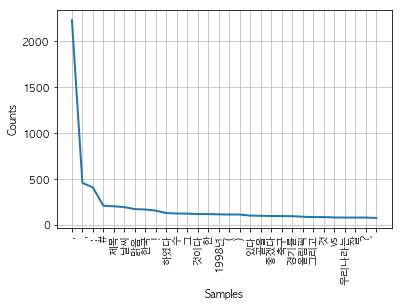

In [48]:
# 토큰화된 형태소의 그래프

text_token_word.plot(30)
#plt.figure(figsize=(30,20))

<Text: NMSC>
<class 'nltk.text.Text'>


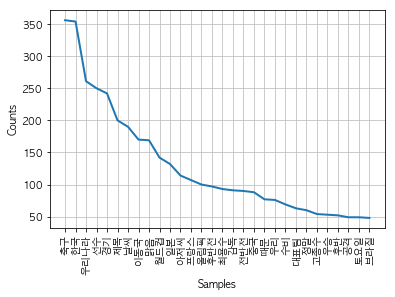

In [49]:
# 명사로만 구성된 그래프

text_token_nouns = nltk.Text(diary_nouns_filter, name='NMSC')
print (text_token_nouns)
print (type(text_token_nouns))

text_token_nouns.plot(30)

### => 그래프 counts 결과로 보았을 때, 
> * '1.축구 2.한국 3.우리나라' 라는 빈도순
> * 이 의미는 다년간의 일기를 통해, Top 3로 도출된 단어들이 모두 국가대표 경기일 경우에 빈번하게 등장한다는 것을 알 수 있고, 따라서 축구를 접한 후 좋아하게 된 계기 중에 핵심이 '애국심'이라고 결론 내릴 수 있다.

---            

#### - 명사들의 빈도수 측정으로 데이터 자료 수치화

In [118]:
# 명사 단어 빈도수 순서 (상위 선수들 이름 선택을 위한 과정)

words_count={}
for word in diary_nouns_filter:
    if word in words_count:
        words_count[word] += 1
    else:
        words_count[word] = 1
sorted_words = sorted([(k,v) for k,v in words_count.items()], 
                      key=lambda word_count: -word_count[1])
print([w[0] for w in sorted_words][:10])

['축구', '한국', '우리나라', '선수', '경기', '제목', '날씨', '이동국', '맑음', '월드컵']


In [53]:
# 명사 단어 빈도수 측정

from collections import Counter
from asq.initiators import query

diary_word_frequency = query(Counter(diary_nouns_filter).most_common()).order_by_descending(lambda pair:pair[1]).then_by(lambda pair:pair[0]).to_list()

In [116]:
diary_word_frequency[:10]

[('축구', 356),
 ('한국', 354),
 ('우리나라', 261),
 ('선수', 250),
 ('경기', 242),
 ('제목', 200),
 ('날씨', 190),
 ('이동국', 170),
 ('맑음', 169),
 ('월드컵', 142)]

### 시각화 (2) 축구선수 언급순위 상위 4명, 연도별 그래프

1. 이동국(170) / 2. 최용수(93) / 3. 고종수(54) / 4. 황선홍(42) / 5. 박진섭(27) / 6. 이영표(26) / 7. 서정원(25) / 8. 안정환(23) / 9. 이상윤(19) / 10. 유상철(18) 

- 아래 연도별로 텍스트 구분을 통해 상위 4명의 선수(이동국, 최용수, 고종수, 황선홍)에 해당하는 언급 빈도수를 나열

In [57]:
import cufflinks as cf

In [58]:
diary_df = pd.DataFrame(np.array([[0, 8, 0, 0], [79, 62, 28, 35], [79, 19, 20, 7], [12, 4, 5, 0]]), 
                  columns = ['이동국', '최용수', '고종수', '황선홍'], index = ['1997년', '1998년', '1999년', '2000년 이후'])
print (diary_df)

          이동국  최용수  고종수  황선홍
1997년       0    8    0    0
1998년      79   62   28   35
1999년      79   19   20    7
2000년 이후   12    4    5    0


In [59]:
import plotly 
plotly.tools.set_credentials_file(username='HYcentreon', api_key='CnJuSC2iBgxMyrgkHxkn')

In [60]:
(diary_df
 .iplot(kind='bar')
)

---

### => 그래프 counts 결과로 보았을 때, 
* 분석결과
> - 일기 수의 차이로 선수들의 언급 빈도수까지 차이 유발 
> - 1997년 : 6개, 1998년 : 100개, 1999년 : 68개, 2000년 : 23개, 2001년 : 4개, 2002년 : 0개, 2003년 : 2개
> - 따라서, 1998년을 기점으로 이동국의 언급 횟수가 상당한 것으로 보아 언론에서나 경기에서 많은 스포트라이트를 받아 일기 쓴 본인에게도 많은 영향이 있을 것이라 생각되었다. 
> - 또한 그 당시, 최용수의 활약으로 1998년 프랑스 월드컵 본선에 진출하고 그 과정 속에서 언급 횟수가 잦아졌다. 
> - 황선홍은 98년 월드컵을 앞둔 직전 부상으로 낙마하면서 그 전 예선 과정 일기 중에 많이 언급되었다. 
> - 고종수는 슈퍼루키 중에 한명으로 이동국과 함께 많은 언급횟수가 나올 것이라 예상된다. 

---

#### - 아래는 각각 연도별 자료를 뽑기 위해 정규표현식으로 나눈 후, 각각의 필요한 데이터 추출

In [61]:
import re

match = re.findall(r'\d+\.\s\d+\S\s\d+\S\s\d+\S',text)
diary_split_year = re.split(r'\#',text)
diary_split_year = diary_split_year[1:]

#print (a[1])
#print ('총 일기개수 :',len(a))
#print (type(a))ㅍ
print (type(diary_split_year))
print (len(diary_split_year))

<class 'list'>
205


In [62]:
print (diary_split_year[1])

2. 1997년 10월 4일 토요일 날씨 : 맑음

주제 : 아랍에미리트를 3-0으로 꺾은 자랑스런, 우리나라 대표 선수단 아저씨들

  우리나라의 수도 서울 잠실에서 아랍에미리트와 축구를 하였다. 지난번에 일본과 아랍에미리트와 0-0 으로 비겼으니까 오늘 우리나라가 아랍에미리트에게 이길 항률(^^: 과거 일기 쓴 맞춤법)이 99%였다. 아랍에미리트는 단지 이길 항률이 1%인 것이다. 전반전에는 아랍에미리트와 우리나라가 절대적인 공격을 하였다. 전반전 7분에 하석주 선수 아저씨가 아랍에미리트 선수를 제끼면서 왼발 슛! 정말 공격적이었다. 우리나라는 전반전에 슛팅을 10번이나 하였다. 코너킥은 아랍에미리트가 한국(우리나라)보다 더 많이 추가하였다. 하지만 골은 우리나라(한국)이 1점을 앞서고 있었다. 정말 기분이 좋았다. 아랍에미리트는 우리나라(한국)에게 쨉도 안 된다. 그러면 우리나라 선수 아저씨들은 식은 죽 먹기 이겠다. 전반전 끝! 심판이 호루라기를 불었다. 좀 있다가 후반전이 시작되었다. 최용수 선수 아저씨가 패널트킥을 하였다. 그래서 유상철 선수 아저씨가 골인을 하였다. 아랍에미리트 0, 우리나라(한국) 2가 되었다. 붉은 악마들은 함성을 질렀다. “한국 이겨라! 제발!” 또 서정원 선수 아저씨가 코너킥의 좀 앞에서 패스를 하였다. 그런데 이상윤 아저씨가 헤딩 슛!을 하였다. 붉은 악마들의 함성소리가 잠실 축구경기장을 휘몰았다. “한국 이겨라!” 정말 아슬아슬 하였다.
  이제 선수 아저씨들에게 편지를 쓰겠다.
  차범근 감독 아저씨, 한국 대표단 선수 아저씨들께
  우리나라를 빛낸 한국 대표단 선수 아저씨들 정말 잘하셨어요.
그리고 첫 골을 터뜨린 하석주 선수 아저씨, 후반전 최용수 선수 아저씨의 패널트킥으로 골인을 눈 것, 서정원 선수 아저씨의 패스, 이상윤 선수 아저씨의 헤딩 슛! 정말 축하드립니다. 차범근 감독 아저씨도 한국 대표단 선수 아저씨들을 훈련을 잘 시키셔서 아랍에미리트를 이긴 것 같습니다.
  남은 경기도 잘해주시기 바랍니다.
1997

In [63]:
# 연도별로 데이터를 뽑기 위해 정규표현식을 이용하여 

def func(year):
    
    lst = []

    for content in diary_split_year:
        try:
            start = re.search(r'\d+\.\s', content).group() + str(year)
            if content.startswith(start):
                lst.append(content)
        except:
            pass
    return lst

---

In [64]:
lst_1997 = func(1997)
lst_1997_text = str(lst_1997)

dong = lst_1997_text.count('이동국')
yong = lst_1997_text.count('최용수')
jong = lst_1997_text.count('고종수')
sun = lst_1997_text.count('황선홍')

print (dong)
print (yong)
print (jong)
print (sun)
len(lst_1997)

0
8
0
0


6

---

In [104]:
lst_1998 = func(1998)
print (lst_1998[0])
len(lst_1998)

7. 1998년 1월 25일 일요일 날씨 : 맑음

제목 : 방콕에서 하는 축구 (킹스컵 국제 축구대회)

  1월 25일 일요일 바로 오늘 방콕에서 한국 국가 선수 아저씨들이 덴마크와 축구를 한다. 그런데 하는 것을 보여주지 않는다. 그 이유는 경제가 어렵기 때문이다. 스포츠 뉴스 아나운서가 지금은 한국이 덴마크에게 1점을 주었다고 말하였다. 중계는 안하지만 한국이 2대1이라도 이겼으면 좋겠다. 중계를 했으면 엄청 좋겠었는데……. IMF시대를 빨리 극복을 하여서 축구중계를 볼 수 있게 했으면 좋겠다. 또 이유가 있다. 영국의 방송국에서 독점중계를 하면서 축구대회의 중계방송하는 비용을 한국의 방송국에 너무 많이 내라고 돈을(달러$) 요구했기 때문에 우리나라 방송국 취소를 했다. 아마도 IMF 때문에 그런 것 같다. 다음에 IMF를 극복하서 꼭 축구중계를 했으면 하늘에 날아갈 것 같은 기분일 것이다.
오늘 아침 덴마크 2-1 한국 우리가 졌다.




100

In [132]:
lst_1998_text = str(lst_1998)

dong = lst_1998_text.count('이동국')
yong = lst_1998_text.count('최용수')
jong = lst_1998_text.count('고종수')
sun = lst_1998_text.count('황선홍')

print (dong)
print (yong)
print (jong)
print (sun)

79
62
28
35


---

In [105]:
lst_1999 = func(1999)
print (lst_1999[0])
len(lst_1999)

107. 1999년 1월 8일 금요일 날씨 : 맑음

제목 : 이동국 꿈

  내가 또 이동국 꿈을 꾸었다. 몇 번째 꿈이냐면 한 4~5번씩 이동국 꿈을 꿔어 보았다. 이번 꿈도 아주 좋은 꿈이었다. 내가 줄거리를 말해보겠다. 이동국의 종교가 불교인데 배경이 우리교회 였다. 이동국은 청년부인데 자기소개를 하였다. 내가 싸인을 받으려고 하니까 이동국이 무슨 색상지를 사려고 어떤 상점에 들어갔다. 나도 따라갔다. 이동국이 색상지를 사고 예수님이 그려진 액자를 사서 교회로 갔다. 그래서 난 싸인을 받고 좋아했다. 그리고 이동국이 소년부에서 자기(이동국)를 좋아하는 사람은 나와 여행을 가자고 해서 나도 이동국의 차를 타고 아주 좋은 여행을 하려고 하는 순간 뻐꾹이 시계 때문에 잠에서 일어났다. 하지만 꿈 속에서는 정말 행복했다. 이동국이 99년에는 더 열심히 했으면 좋겠다. 또 오늘 밤 이동국 꿈을 꿈을 꾸었습니다.




68

In [42]:
lst_1999_text = str(lst_1999)

dong = lst_1999_text.count('이동국')
yong = lst_1999_text.count('최용수')
jong = lst_1999_text.count('고종수')
sun = lst_1999_text.count('황선홍')

print (dong)
print (yong)
print (jong)
print (sun)

79
19
20
7


---

In [103]:
lst_2000 = func(2000)
print (lst_2000[0])
len(lst_2000)

177. 2000년 1월 6일 목요일 날씨 : 구름

제목 : 축구

  동네 아이들과 축구를 하였다. 학교 갈 때에는 놀 시간이 없어 토요일에 밖에 나가서 놀았다. 하지만 방학이 된 뒤로 거의 매일 시간이 있을 때만 밖에 나가서 논다. 동네 꼬마들하고 논다기에 유치하기 그지 없지만 꼬마 아이들과 놀아도 시간 가는 줄 모른다. 내가 축구에 좀 정신이 나갔지만 제 할 일을 다 하고 축구에 관한 것을 한다. 축구도 다 장점이 있는 법. 축구도 장점을 찾아보면 아주 좋은 남녀노소 누구나 즐길 수 있는 놀이이다. 한국축구의 발전을 위해 파이팅!




23

In [44]:
lst_2000_text = str(lst_2000)

dong = lst_2000_text.count('이동국')
yong = lst_2000_text.count('최용수')
jong = lst_2000_text.count('고종수')
sun = lst_2000_text.count('황선홍')

print (dong)
print (yong)
print (jong)
print (sun)

12
2
0
0


---

In [108]:
lst_2001 = func(2001)
print (lst_2001[0])
len(lst_2001)

200. 2001년 1월 3일 수요일

제목 : 한 ? 일 올스타 vs 세계 올스타

  정말 대등하고도 이길 수 있었던 경기였다. 2002년 한 ? 일 공동개최로 인해 한국 선수들과 일본 선수들이 한 팀이 되어 뛸 것을 이번이 처음이다.
  세계 올스타 팀에는 마테우스, 칠라베르트 등 쟁쟁한 선수들이 있었지만 한 ? 일 올스타 팀은 대등하게 맞섰다. 한 ? 일 올스타 팀은 역시 조직력이 좋았다. 한 ? 일 올스타 팀의 게임메이커는 앙팡 테리블의 고종수, 세계 올스타 팀은 아르헨티나의 희망인 오르데가로 게임을 주도하였다.
  전반전 17분 결정적인 순간이었다. 우리 한 ? 일 올스타 팀이 페널티킥 약간 벗어난 지점에서 프리킥을 얻었다. 그 때 한 ? 일 올스타 팀에는 고종수가 있었다. 고종수가 왼발 인사이드 킥으로 골문 안으로 빨려 들어갔다. 정말 환상적이었다.
  전반에 고종수가 넣기 전, 최용수가 계속 골문을 열어보려고 했지만 빗나가고 있었는데 절묘한 프리킥으로 골을 넣으니 속이 시원했다.
  몇 번의 슛팅을 주고 받는데 일명 ‘골 넣는 골키퍼’라 불리는 칠라베르트가 프라킥을 찼는데 골이 되지는 못 했다. 칠라베르트와 김병지는 같이 골 넣는 골키퍼로서 대결을 한 것인데 대등한 것 같았다. 칠라베르트도, 김병지도, 선방을 여러 차례 하였다. 이로써 전반전이 끝났다.
  후반전을 알리는 주심의 휘슬 소리가 요코하마 경기장에 울려퍼졌다. 한 ? 일 올스타와 세계 올스타에서 선수 교체가 많이 이루어졌다. 한국은 공격에서 수비로, 일본은 수비에서 공격으로 뛰기 시작했다. 일본의 미우라도 합류하면서 나카야마와 슛팅을 여러 번 하였다. 그러나 골키퍼가 교체되었어도 세계 선수는 선수가 보다. 여러 선방도 “턱턱” 잘 막아내고.
  세계 올스타에서 후반전에 교체되어 들어온 프로시비츠키가 후반전 27분 결정적인 역할을 했다. 개인기로 두 명 정도 제치고 중거리 슛. 한 ? 일 올스타 팀의 골문으로 빨려 들어갔다. 그래도 우리가 이겼으면 했는데……. 시간이 남긴 남았다. 미우

4

In [46]:
lst_2001_text = str(lst_2001)

dong = lst_2001_text.count('이동국')
yong = lst_2001_text.count('최용수')
jong = lst_2001_text.count('고종수')
sun = lst_2001_text.count('황선홍')

print (dong)
print (yong)
print (jong)
print (sun)

0
1
5
0


---

In [109]:
lst_2002 = func(2002)
print (lst_2002)
len(lst_2002)

[]


0

---

In [110]:
lst_2003 = func(2003)
print (lst_2003[0])
len(lst_2003)

204. 2003년 7월 30일 수요일

제목 : 코엑스에서 (방학숙제로 쓴 일기)

  방학숙제 참 코엑스에 축구 전시회를 보러 엄마와 함께 갔다. 슬프게도 아빠와 내 동생은 외가 친척들과 휴가를 갔지만 외로움을 식히러 간 것이다.
  퇴약볕 속에서 지하철을 탄 후 삼성역에서 내려 코엑스 전시장으로 향했다. 그 사이에 옷 구경도 하며 갔다.
  축구 전시장은 코엑스 전시장 2층에 자리잡고 있었다. 진시황과 공예 대전, 그 다음에 그 전시장이 있었다. 들어갈 때 마지막 날이어서 그런지 우리나라 선수들이 찍힌 사진첩이 한 장밖에 없었는데 다행히 그 한 장을 가질 수 있어서 거기까지는 좋았다.
  하지만 딱 들어가고 나니 바로 그 자리에서 실망하고 말았다. 축구 전시는 고사하고 완전 놀자판 이었다. MBC에서 후원해 준 옷, 접시, 인형 등 물건을 팔고, 어떤 축구 유니폼 입은 애들은 그냥 놀고… 정말 그런게 전시 문화라고 할 수 있을지 답답하기만 했다. 전시물도 있었긴 있었지만 거의 없었다고 해도 과언이 아니다. ‘어쩐지 무료더라!’ 하는 생각도 스쳐 지나갔다.
  내 꿈은 나중에 영국에서 축구 전문 전력 분석가가 되는 것이다. 그래서 코치도 하고, 축구 분야의 마케팅 전문가가 되어 축구 발전을 도모하기도 하는 것이다. 내가 꼭 그 꿈을 이루어 우리나라에 이러한 전시 문화가 정착되는 것이 아니라 무료더라도 무언가 얻어 갈 수 있는 그런 전시 문화를 발전시켜야겠다고 결심했다.
  축구 전시를 한 5분간 관람하고 그 옆쪽에 있었던 공예 대전에서 실망했던 마음을 조금이나마 달랬다. 엄청난 손재주에 감탄도 하고 말이다.
  몇 년 후에는 축구 전시 문화가 발전되기를 바라며 돌아왔다.




2

In [49]:
lst_2003_text = str(lst_2003)

dong = lst_2003_text.count('이동국')
yong = lst_2003_text.count('최용수')
jong = lst_2003_text.count('고종수')
sun = lst_2003_text.count('황선홍')

print (dong)
print (yong)
print (jong)
print (sun)

0
1
0
0


---

### (2) 워드클라우드

앞에서 전처리한 전체 일기의 텍스트를 워드클라우드로 시각화하여 키워드를 찾아보도록 하자.
기본 설정에는 한글폰트가 없으므로 한글을 나타내기 위해서는 한글 폰트를 직접 지정해주어야 한다.

In [68]:
from wordcloud import WordCloud
font_file = 'resources/Daum_SemiBold.ttf'
WC = WordCloud(font_path=font_file, width=700, height=700)
#diary_nouns_WC = open(str(diary_nouns_filter)).read()
diary_nouns_WC = open('intermediate/diary_nouns_filter.txt').read()

In [69]:
print (diary_nouns_WC[:100])
print (type(diary_nouns_WC)) # str

일요일 날씨 맑음 주제 역전승 우리나라 한국 대표 선수 아저씨 파이팅 월드컵 최종 경기 응원 악마 응원 불타 처음 우리나라 공격 일본 공격 고정운 선수 아저씨 실수 일본 골인 한국
<class 'str'>


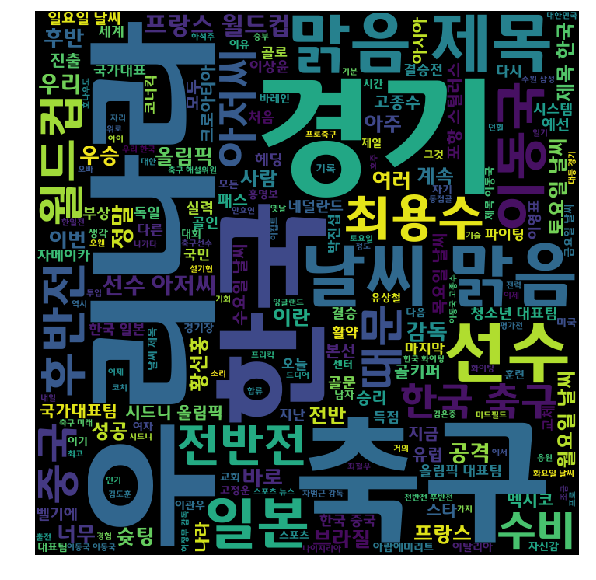

In [70]:
# 전체 텍스트에 대한 워드클라우드

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(font_path='resources/Daum_SemiBold.ttf',
                          background_color='black',
                          width=700,
                          height=700
                         ).generate(diary_nouns_WC)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### => 워드클라우드 생성 시

> * 명사의 빈도수에 따라 시각화 됨을 확인할 수 있다.
> * 축구일기라, '축구'와 '경기'라는 단어가 눈에 띄고, 거의 모든 일기에 썼던 '날씨'와 '맑음' 이라는 단어도 큰 부분을 차지한다.
> * 아저씨라는 단어가 꽤 큰 글씨 크기를 차지하는 이유가 당시 축구선수들의 호칭을 모두 아저씨로 기록했다는 것도 그 이유가 된다.
> * 선수의 빈도 수를 통해 볼 수 있듯이, 여기서도 선수 중에 Top 2에 해당하는 '최용수'와 '이동국'이 눈에 띈다는 것을 볼 수 있다.

---

### (3) Word2Vec

gensim이라는 패키지에 구현된 Word2Vec이라는 클래스로 구현되어 있다. 단어 임베딩을 위한 코퍼스(리스트의 리스트 형태)를 만든 후 대입 및 도출하여 단어 간의 유사도를 판단하고 측정

In [71]:
from gensim.models.word2vec import Word2Vec

In [72]:
len(diary_double_list)

12473

In [73]:
%%time
model = Word2Vec(diary_double_list)

CPU times: user 193 ms, sys: 4.06 ms, total: 197 ms
Wall time: 179 ms


In [77]:
model.wv.index2word[:10]

['축구', '한국', '우리나라', '선수', '경기', '제목', '날씨', '이동국', '맑음', '월드컵']

In [78]:
model.init_sims(replace=True)

In [82]:
model.similarity('축구', '이동국')

0.050003860921996872

In [83]:
model.most_similar("골인")

[('우즈베키스탄', 0.2989950180053711),
 ('순간', 0.2573654353618622),
 ('미드필더', 0.25542405247688293),
 ('네트', 0.24753338098526),
 ('티켓', 0.2263541966676712),
 ('원정', 0.22166752815246582),
 ('멤버', 0.21390166878700256),
 ('점수', 0.21244964003562927),
 ('탈락', 0.2085549533367157),
 ('헤딩골', 0.20721784234046936)]

In [84]:
diary_word2vec = pd.DataFrame(model.wv.index2word)

In [85]:
diary_word2vec_list = list(model.wv.vocab.keys())

In [86]:
diary_word2vec_df = pd.DataFrame(diary_word2vec_list)

In [92]:
diary_word2vec_df[:10]

,0
0,일요일
1,날씨
2,맑음
3,주제
4,우리나라
5,한국
6,대표
7,선수
8,아저씨
9,파이팅


In [101]:
# 결과값 : 

len(model.wv.vocab)

501

In [102]:
diary_model_vector = model[model.wv.vocab] # voca 하나하나당 벡터화

In [103]:
print (diary_model_vector)
print (type(diary_model_vector))
print (diary_model_vector.shape)

[[ 0.10024562 -0.06883525 -0.07697731 ..., -0.14581749  0.16178848
  -0.11314157]
 [ 0.09184683  0.15079863  0.01507238 ..., -0.01112634  0.02172859
  -0.12401038]
 [-0.0887033   0.13348405  0.0098109  ...,  0.15208445 -0.09729795
   0.00037611]
 ..., 
 [ 0.16565987  0.11264312 -0.05937849 ...,  0.15817669 -0.07939409
  -0.13977771]
 [ 0.0345225  -0.16582032  0.03472244 ..., -0.16878562 -0.11515221
   0.13518128]
 [ 0.01255446 -0.09871581 -0.05675224 ...,  0.16653195  0.14604184
  -0.14910394]]
<class 'numpy.ndarray'>
(501, 100)


### => Word2Vec으로 나온 결과값에 대한 분석

> * model.similarity에서 corpus내에 있는 단어들을 입력하면 그 유사도가 측정된다.
> * model.most_similar로 입력한 단어와 유사도가 높은 순서대로 차례대로 도출된다.

---

### (4) Word2Vec 결과를 통한 T-SNE

* t-SNE(t-Distributed Stochastic Neighbor Embedding)란 비선형 차원축소, 시각화를 위해 주로 사용 
* 데이터 포인트들 사이의 유사도를 통해 데이터의 패턴을 찾고, 고차원의 데이터를 저차원의 공간으로 매핑하는데 목적

In [104]:
diary_model_vector_df = pd.DataFrame(diary_model_vector, index=diary_word2vec_list)
diary_model_vector_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
일요일,0.100246,-0.068835,-0.076977,0.171853,0.125624,0.134375,0.002560,0.127949,-0.077191,0.146613,...,-0.040833,-0.034514,-0.139333,0.047972,0.032156,-0.043985,-0.060317,-0.145817,0.161788,-0.113142
날씨,0.091847,0.150799,0.015072,-0.151001,-0.108605,0.114730,0.151363,0.162761,0.169101,-0.034482,...,0.026016,-0.168565,0.064891,-0.068462,-0.048487,-0.129111,-0.162303,-0.011126,0.021729,-0.124010
맑음,-0.088703,0.133484,0.009811,0.124285,0.095521,0.151296,0.001376,-0.118782,-0.137232,-0.055474,...,0.087460,-0.010345,-0.074277,-0.067999,0.009982,-0.113154,0.089394,0.152084,-0.097298,0.000376
주제,-0.082893,0.041149,-0.031478,-0.080948,0.143145,-0.059303,0.092875,0.052256,0.171347,0.106317,...,-0.034680,0.109929,-0.171024,-0.034114,0.034150,-0.123893,-0.024161,0.062091,-0.144149,0.035117
우리나라,0.112364,0.105769,-0.121824,0.139349,0.119038,0.061403,-0.031352,-0.049829,0.139728,-0.026900,...,-0.081500,0.010972,0.078145,-0.061367,-0.162488,0.163347,-0.019783,-0.106457,0.135398,0.076157


In [105]:
vect_tsne = TSNE(n_components = 2, random_state=0)
np.set_printoptions(suppress=True)

In [106]:
diary_model_vector_df.shape

(501, 100)

In [107]:
diary_model_vector_df.values

array([[ 0.10024562, -0.06883525, -0.07697731, ..., -0.14581749,
         0.16178848, -0.11314157],
       [ 0.09184683,  0.15079863,  0.01507238, ..., -0.01112634,
         0.02172859, -0.12401038],
       [-0.0887033 ,  0.13348405,  0.0098109 , ...,  0.15208445,
        -0.09729795,  0.00037611],
       ..., 
       [ 0.16565987,  0.11264312, -0.05937849, ...,  0.15817669,
        -0.07939409, -0.13977771],
       [ 0.0345225 , -0.16582032,  0.03472244, ..., -0.16878562,
        -0.11515221,  0.13518128],
       [ 0.01255446, -0.09871581, -0.05675224, ...,  0.16653195,
         0.14604184, -0.14910394]], dtype=float32)

In [108]:
diary_tsne = vect_tsne.fit_transform(diary_model_vector_df) 

# 선생님 코드 비교
# X_tsne = tsne_points
# vect_tsne = TSNE(random_state=0)

In [109]:
print (diary_tsne)

[[ -4.30484981  17.58682948]
 [ 11.41205537  14.31941915]
 [ -0.95020075 -11.19408196]
 ..., 
 [ -4.06228908  -2.81458665]
 [  0.78082983  19.79407671]
 [-13.34623747   7.05668311]]


In [112]:
tsne_df = pd.DataFrame(diary_tsne, index=None, columns = ['x_coord', 'y_coord'])
tsne_df['word'] = diary_word2vec_list
tsne_df[:10]

,x_coord,y_coord,word
0,-4.304850,17.586829,일요일
1,11.412055,14.319419,날씨
2,-0.950201,-11.194082,맑음
3,-22.608665,-12.448699,주제
4,24.498195,3.972773,우리나라
5,-12.479107,-8.935128,한국
6,-13.054982,-14.331726,대표
7,-1.574103,-1.746168,선수
8,-7.439632,-0.619386,아저씨
9,17.288942,-18.491807,파이팅


In [113]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

Loading BokehJS ...

In [119]:
# prepare the data in a form suitable for bokeh.
plot_data = ColumnDataSource(tsne_df)

# create the plot and configure it
tsne_plot = figure(title='t-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   active_scroll='wheel_zoom'
                  )

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = '@word') )

tsne_plot.circle('x_coord', 'y_coord', source=plot_data,
                 color='blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color='orange')

# adjust visual elements of the plot
tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# show time!
show(tsne_plot);

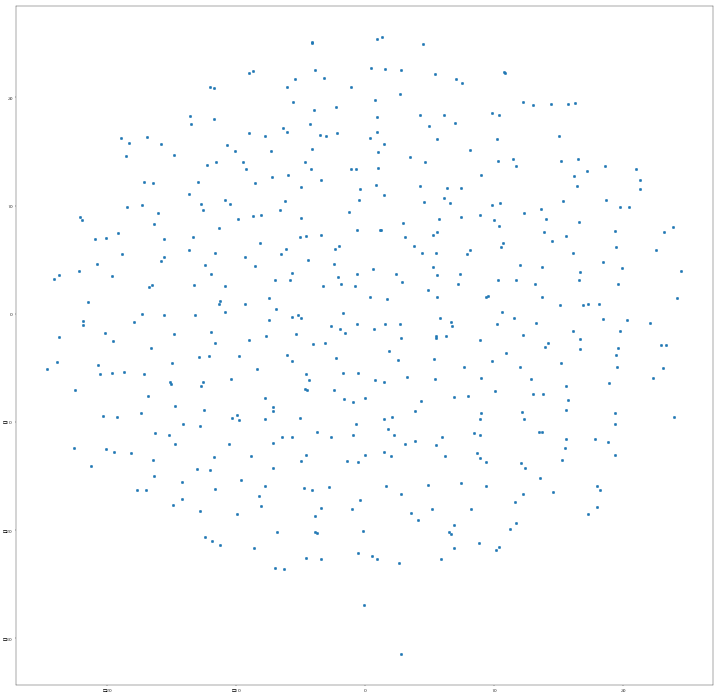

In [115]:
Plot.figure(figsize=(30, 30), dpi=30)
plt.scatter(diary_tsne[:, 0], diary_tsne[:, 1])
plt.show()

### => 시각화된 t-sne 그래프 분석

> * 단어 갯수가 대략 500개에 불과하고, 전체적으로 퍼져있는 상태로 표현되어 있다. 따라서, 단어와 단어간의 유사성을 판단하기가 쉽지 않다.

---

## 5. 일기 텍스트 생성

일기 데이터 셋의 날짜와 주제 부분을 빼고 내용만으로 이루어진 txt 파일 생성 후, RNN을 활용해 텍스트 생성

> diary_test 파일에 존재